# Flow Matching

We show in this notebook how OTT can be used to estimate a time-dependent velocity field that can flow from a source to a target distribution following the {term}`flow matching` approach
(e.g. {cite}`albergo:23`, {cite}`lipman:22`). We explore three different approaches to couple source to target points, either the independent coupling that is the standard choice in flow matching, batch OT couplings (using the {term}`Sinkhorn algorithm`) or through a solution to the 
{term}`semidiscrete problem` (see {cite}`tong:23`, {cite}`pooladian:23`, {cite}`zhang:25`, {cite}`mousavi:25`).

In [1]:
# Basic imports
import warnings
from collections.abc import Iterable
from typing import Callable, Dict, Literal, Optional, Tuple

from tqdm.notebook import tqdm

import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np

import optax
from flax import nnx

import matplotlib.pyplot as plt

# OTT geometries
from ott.geometry import costs
from ott.geometry import semidiscrete_pointcloud
from ott.geometry import semidiscrete_pointcloud as sdpc

# Flow matching backbone
from ott.neural.data import ot_dataloader
from ott.neural.methods import flow_matching as fm
from ott.neural.networks.velocity_field import mlp

# Semidiscrete couplings
from ott.problems.linear import semidiscrete_linear_problem as sdlp
from ott.solvers.linear import semidiscrete
from ott.tools import plot

warnings.filterwarnings("ignore", ".*Animation was deleted without rendering.*")

## Define synthetic task through ground truth Brenier potential

We pick a convex function $\varphi$ to define a {term}`Monge map` $\nabla\varphi$ that is optimal w.r.t. the squared-Euclidean distance, per the {term}`Brenier theorem`. Namely, we can pick a starting measure $\mu$, and define $\nu:= \nabla \varphi\#\mu$ and can guarantee that $\nabla\varphi$ is the optimal map linking $\mu$ to $\nu$, whatever the measure $\mu$.

In [2]:
# Define ground truth potential phi
A = jnp.array(((-0.8, 0.4), (-0.1, -0.5)))  # linear transform
B = jnp.array(((0.5, 0), (0, 0.5)))  # positive definite matrix.

assert jnp.linalg.det(B) > 0.0, jnp.linalg.det(B)


def phi(x: jnp.ndarray) -> jnp.ndarray:
    """Real-valued convex potential function."""
    return (
        2 * jnp.sum(jnp.abs(A @ x) ** 1.7)
        + jnp.sum(jnp.exp(B @ (x - 15)))
        + jnp.sum(jnp.abs(x - 1))
        + jnp.sum(jnp.abs(x - 2))
        + jnp.sum(jnp.abs(x - 7))
    )

We can plot the contours of that potential.

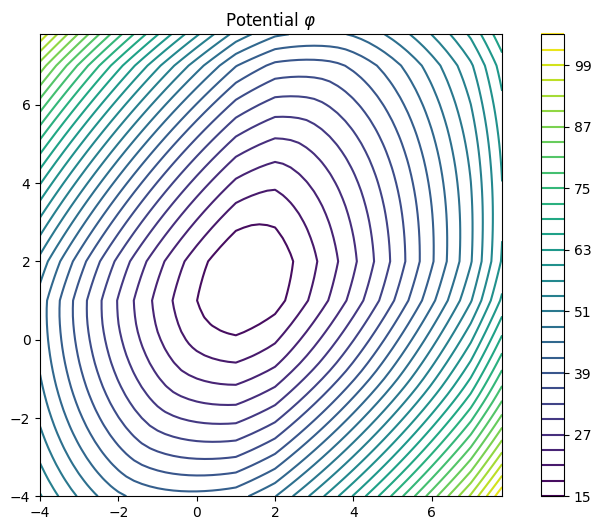

In [3]:
x = np.arange(-4, 8.0, 0.2)
y = np.arange(-4, 8.0, 0.2)
X, Y = np.meshgrid(x, y)
Z = jnp.array([jnp.array([xx, yy]) for xx, yy in zip(np.ravel(X), np.ravel(Y))])
Z = jax.vmap(phi)(Z).reshape(X.shape)
fig, ax = plt.subplots(figsize=(10, 6))
plt.contour(X, Y, Z.reshape(X.shape), levels=30)
ax.set_aspect("equal")
plt.title(r"Potential $\varphi$")
plt.colorbar()
plt.show()
plt.close()

We leverage these ground truth {term}`Monge map` and ground truth {term}`Benamou-Brenier` velocity fields to define data to create a synthetic task that we will solve using {term}`flow matching`.

We do so by defining a source distribution, a union of two 2D toruses. We sample a few points from that distribution for plotting purposes.

In [4]:
full_plot = 2048
batch_plot = 256
hl_batch_plot = 32  # Smaller batch to highlight in plots.

# Generate point cloud near the unit circle.


def gen_torus_points(key: jax.Array, fraction: float = 0.7, size: int = 1):
    points = jr.normal(key, (size, 2))
    points /= jnp.linalg.norm(points, axis=-1, keepdims=True) + 1e-8
    torus_norms = 2 * (1 - fraction) * jr.uniform(jr.key(1), (size,)) + fraction
    points *= torus_norms[:, None]
    return points


def gen_points(rng: jax.Array, batch_size: int, dtype=None):
    x = 3 * jnp.array(gen_torus_points(rng, size=batch_size // 2), dtype=dtype)
    y = 2 * jnp.array(
        gen_torus_points(rng, size=batch_size // 2, fraction=0.8), dtype=dtype
    ) + jnp.array((8, 2))
    return jnp.concatenate((x, y))


points = gen_points(jr.key(0), batch_size=full_plot)
points_sub = jr.choice(jr.key(1), points, (batch_plot,), axis=0)
hl_points = gen_points(jr.key(2), batch_size=hl_batch_plot)

### Data and Monge Solution

We plot source points and the {term}`push-forward` measure obtained by
applying $\nabla\varphi$ to these source points.

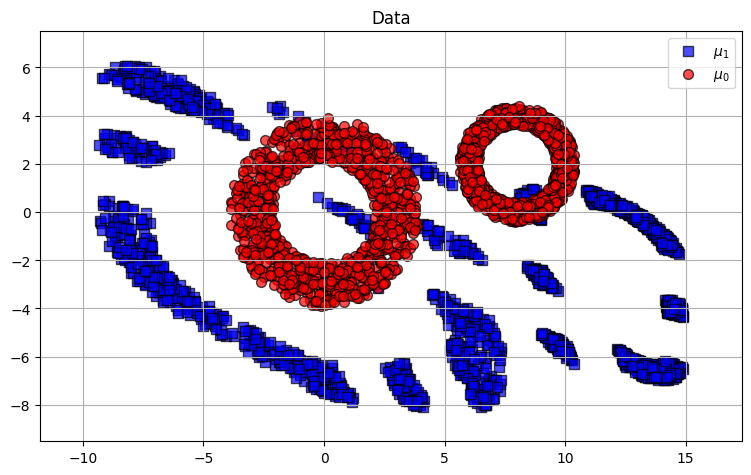

In [5]:
_ = plot.transport_animation(
    n_frames=1,
    title="Data",
    static_source_points=points,
    brenier_potential=phi,
)

We show more explicitly the {term}`Monge map` linking each source point to its target point, on a subset of points.

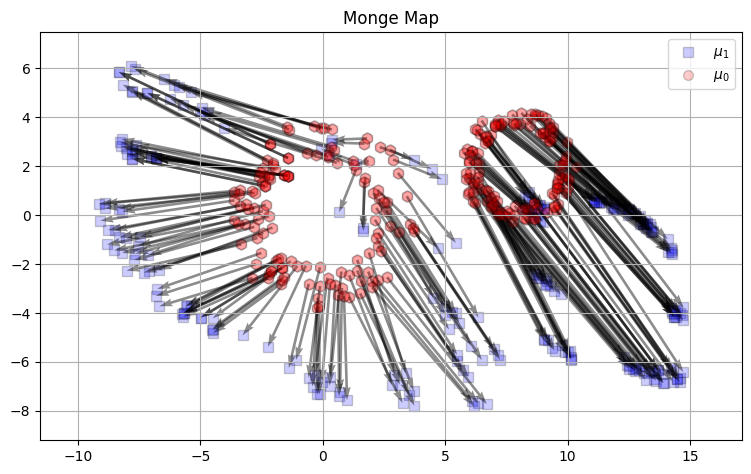

In [6]:
_ = plot.transport_animation(
    n_frames=1,
    title="Monge Map",
    static_source_points=points_sub,
    plot_monge=True,
    brenier_potential=phi,
)

### McCann Interpolation


This {term}`Monge map` can be presented in a dynamic view, by plotting all barycenters linking source points to target points, $x_t=(1-t)x + t \nabla\varphi(x)$, to form the so-called McCann interpolation {cite}`mccann:97`.

In [7]:
_ = plot.transport_animation(
    n_frames=11,
    title="McCann Interpolation",
    static_source_points=points_sub,
    plot_dynamic_transport=True,
    brenier_potential=phi,
)

### Independent Interpolant

The McCann interpolation (which requires the knowledge of the optimal transport map) can be compared with the independent interpolant {cite}`albergo:23`, which is far easier to compute since it involve sampling independently a point from the source, then the target, and then linking them.

In [8]:
for plot_ifm_arrows in [False, True]:
    _ = plot.transport_animation(
        n_frames=11,
        title="Flow-Matching Interpolant"
        + (" + Velocity of some points" if plot_ifm_arrows else ""),
        static_source_points=points_sub,
        plot_ifm_interpolant=True,
        plot_ifm_arrows=plot_ifm_arrows,
        brenier_potential=phi,
    )

### Benamou-Brenier Solution

Since this is a synthetic example, we can show what the {term}`Benamou-Brenier` solution looks like, by displaying the time and space varying vector field $\Delta t \times v_t(\cdot)$. Here $\Delta t$ is the inverse of `(n_frames-1)`.

In [9]:
_ = plot.transport_animation(
    n_frames=11,
    title="Benamou-Brenier Velocity",
    n_grid=21,
    static_source_points=points,
    brenier_potential=phi,
)

And illustrate that integration more carefully on one subset of highlighted points.

In [10]:
_ = plot.transport_animation(
    n_frames=11,
    title="Benamou-Brenier Integration",
    n_grid=21,
    static_source_points=points,
    dynamic_points=hl_points,
    plot_dynamic_transport=True,
    brenier_potential=phi,
)

## Flow Matching

### Coupling Approaches

#### Independent Coupling

We first instantiate a data sampler that leverages the knowledge of the ground truth transport map, but returns unpaired data.

In [11]:
def unpaired_dl(
    rng: jax.Array,
    batch_size: int,
    potential: Callable[[jnp.ndarray], jnp.ndarray],
):
    while True:
        rng, rng_x0, rng_x1 = jr.split(rng, 3)
        x0 = gen_points(rng_x0, batch_size)
        x1 = jax.vmap(jax.grad(potential))(gen_points(rng_x1, batch_size))
        yield x0, x1


batch_size = 256
dl_ind = unpaired_dl(jr.key(23), batch_size=batch_size, potential=phi)

In [12]:
dl_iter = iter(dl_ind)
x0, x1 = next(dl_iter)
x0[0:3, :]

Array([[-1.1207995, -2.6633139],
       [ 1.0238404,  2.8844364],
       [-2.8932962, -0.2328775]], dtype=float32)

#### Batch-OT Coupling

We now build an OT-FM sampler that resolves pairs provided independently, using an OT solver (here the {term}`Sinkhorn algorithm`)

In [13]:
dl_ot = ot_dataloader.LinearOTDataloader(
    rng=jr.key(0), dataset=dl_ind, epsilon=0.05, relative_epsilon="std"
)

#### Semidiscrete Coupling

Finally, we instantiate the semidiscrete coupling approach. Unlike the two methods above, where the data samplers draw from a continuous density, this assumes that the target dataset is *finite*. 

In [14]:
# Semidiscrete pairs sampler, finite target sampled once
size_target = 2048
target_points = jax.vmap(jax.grad(phi))(gen_points(jr.key(64), size_target))

# Instantiate the SD geometry object
pc = sdpc.SemidiscretePointCloud(
    sampler=lambda r, s, d: gen_points(r, s[0], d),
    y=target_points,
    epsilon=0.0,
    cost_fn=costs.NegDotProduct(),
)

sdpb = sdlp.SemidiscreteLinearProblem(pc)

num_iterations = 10_000
schedule = optax.linear_schedule(
    init_value=10,
    transition_begin=num_iterations // 4,
    transition_steps=num_iterations // 2,
    end_value=0.05,
)

error_eval_every = 500

pbar = tqdm(range(num_iterations), desc="SD Estimation")


def print_callback(state: semidiscrete.SemidiscreteState) -> None:
    it = state.it.item()
    if it > 0 and it % error_eval_every == 0:
        loss = state.errors[it // error_eval_every - 1].item()
        pbar.set_postfix(χ2=f"{loss:.4f}", 𝜀=f"{state.epsilon:.4f}")
        pbar.update(error_eval_every)


solver = semidiscrete.SemidiscreteSolver(
    num_iterations=num_iterations,
    batch_size=512,
    optimizer=optax.sgd(learning_rate=schedule),
    error_eval_every=error_eval_every,
    callback=print_callback,
    epsilon_scheduler=lambda it, te: te + 0.1 * jax.nn.relu(1000 - it) / 1000,
)
sd_out = jax.jit(solver)(rng=jr.key(2), prob=sdpb)

SD Estimation:   0%|          | 0/10000 [00:00<?, ?it/s]

Now that the semidiscrete problem has been solved, we can check visually whether the estimation is satisfactory. We simply evaluate a batch of noise, and plot where it has been mapped. Ideally, that distribution of points should *roughly* match that which was used initially.

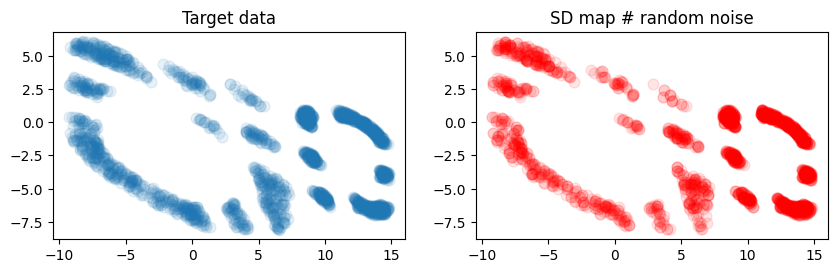

In [15]:
dl_sd_plot = sd_out.to_dataloader(jr.key(0), batch_size=size_target)

p, e_p = next(iter(dl_sd_plot))

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].scatter(pc.y[:, 0], pc.y[:, 1], s=60, alpha=0.1)
ax[0].set_aspect("equal")
ax[0].set_title("Target data")
ax[1].scatter(e_p[:, 0], e_p[:, 1], color="r", s=60, alpha=0.1)
ax[1].set_aspect("equal")
ax[1].set_title("SD map # random noise")
plt.show()

# Dataloader with the correct batch_size to be used for training
dl_sd = sd_out.to_dataloader(jr.key(0), batch_size=batch_size)

### Training of Velocity Fields

We propose a simple training loop, that uses a dataloader to sample source/target pairs, and simply interpolates between them to form random points, barycenters, and directions the velocity field can be regressed on.

In [16]:
def train_loop(
    rng: jax.Array,
    dl: Iterable[tuple[jax.Array, jax.Array]],
    name: str = "",
    num_iters=20_000,
) -> mlp.MLP:
    model = mlp.MLP(dim=2, rngs=nnx.Rngs(1), hidden_dims=[64, 64])
    optimizer = optax.adam(1e-3)
    optimizer = nnx.Optimizer(model, optimizer, wrt=nnx.Param)

    fm_step = nnx.jit(fm.flow_matching_step)
    step_rngs = nnx.Rngs(0)

    pbar = tqdm(range(num_iters), desc=name + " training")
    log_every = 100
    dl_iter = iter(dl)
    for i in range(num_iters):
        rng, rng_batch = jr.split(rng)
        batch = fm.interpolate_samples(rng_batch, *next(dl_iter))
        metrics = fm_step(model, optimizer, batch, rngs=step_rngs)

        if i % log_every == 0:
            pbar.set_postfix(loss=f"{float(metrics['loss']):.4f}")
            pbar.update(log_every)

    return model

We train three different models, one for each approach: independent coupling, batch-OT coupling and semidiscrete coupling.

In [17]:
models = []

dls = [dl_ind, dl_ot, dl_sd]
method_names = ["IFM", "OTFM", "SDFM"]

for dl, meth_name in zip(dls, method_names):
    models.append(train_loop(jr.key(0), dl=dl, name=meth_name))

IFM training:   0%|          | 0/20000 [00:00<?, ?it/s]

OTFM training:   0%|          | 0/20000 [00:00<?, ?it/s]

SDFM training:   0%|          | 0/20000 [00:00<?, ?it/s]

We can see that there are clear differences between the three learned vector fields. I-FM struggles to cover target modes and its velocity field wiggles more sharply across space. OTFM manages to recover an acceptable solution. It is likely that increasing the batch size would improve its performance further, for an additional compute cost. SDFM performs fairly well and results in a better conditioned velocity field overall.

In [18]:
for model, meth_name in zip(models, method_names):
    plot.transport_animation(
        n_frames=11,
        title=meth_name,
        n_grid=21,
        static_source_points=points,
        velocity_field=model,
        brenier_potential=phi,
        dynamic_points=hl_points,
        plot_dynamic_transport=True,
    )